In [13]:
""" import useful functions """

import matplotlib.pyplot as plt 
from scipy.integrate import odeint, solve_bvp
import pyccl as ccl
import numpy as np
import scipy
import seaborn as sns
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import inset_axes 
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import mpmath as mp
from decimal import Decimal, getcontext

%matplotlib inline

## Define useful functions

In [4]:
""" define background functions """

# Equation 2.14
def Omega_Lambda(cosmo):
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    
    return 1 - Omega_m - Omega_r - Omega_k + alpha_tilde * (1 - C_t**2 + Omega_k**2 - 2*Omega_k)

# Equation 2.13
def X(z, cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)
    
    return 1 + 4 * alpha_tilde * (Omega_m * (1 + z) ** 3 + (Omega_r + alpha_tilde*C_t**2) * (1 + z)** 4 + Omega_lambda)

# Equation 2.12
def E(z , cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)
    
    if alpha_tilde == 0:
        ans = np.sqrt(Omega_m * (1 + z) ** 3 + Omega_r * (1 + z) ** 4 + Omega_k * (1 + z) ** 2 + Omega_lambda)
    else:
        ans = np.sqrt((np.sqrt(X(z , cosmo)) - 1 + (2 * alpha_tilde * Omega_k * (1+z) ** 2))/(2 * alpha_tilde))
    
    return ans

# gives dE/dz

def dEdz(z , cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)
    
    # Wang and Mota
    dEdz = Omega_k *(1 + z)/E(z , cosmo) + ((3 * Omega_m * (1 + z) ** 2)+(4 * (Omega_r + alpha_tilde*C_t**2) * (1 + z) ** 3))/\
           (2 * E(z , cosmo) * np.sqrt(X(z , cosmo)))
    
    return dEdz

# gives rho_cdm / rho_DE as a function of z for k = 0


def rho_cdm_frac_rho_de(z , cosmo):
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)
    
    E_eval = E(z, cosmo)
    
    frac = Omega_c * (1+z) ** 3 / (Omega_lambda - alpha_tilde*(E_eval ** 4 - 2 * Omega_k * E_eval ** 2 * (1 + z) ** 2))
    return frac

# find w = P / pho for dark energy   -- for k = 0


def omega_de(z , cosmo):
    
    Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t = cosmo
    Omega_m = Omega_c + Omega_b
    Omega_lambda = Omega_Lambda(cosmo)
    
    E_eval = E(z, cosmo)
    
    ans = - 1 - (4 * alpha_tilde * (1 + z) * E_eval ** 3 * dEdz(z , cosmo)) / \
                (3 * (Omega_lambda - alpha_tilde*(E_eval ** 4)))
    
    return ans

def unitless_time(z , cosmo):
    t = np.zeros(len(z))
    for i in range(len(z)):
        t[i] = scipy.integrate.quad(lambda x: 1/(x*E(1/x -1,cosmo)), 0 , 1/(1+z[i]))[0]
    return t

# sound horizon
def r_s_fracH0c(z,cosmo, a_min):
    Omg_c , Omg_b , Omg_k , Omg_r, alpha_t, C_t = cosmo
    Omg_m = Omg_b + Omg_c 
    
    return mp.quad(lambda x: 1/((x**2)*E(1/x -1, cosmo)*np.sqrt(3*(1 + R_b(Omg_b*h**2)*x))), [a_min, 1/(1+z)])

# particle horizon
def r_hor_fracH0c(z,cosmo, a_min):
    Omg_c , Omg_b , Omg_k , Omg_r, alpha_t, C_t = cosmo
    Omg_m = Omg_b + Omg_c 
    
    return mp.quad(lambda x: 1/((x**2)*E(1/x-1, cosmo)), [a_min, 1/(1+z)])

# Used to find z_CMB
def g1(wb):
    return (0.0783*wb**(-0.238))/(1 + 39.5*wb**(0.763))

# Used to find z_CMB
def g2(wb):
    return 0.56/(1 + 21.1*wb**(1.81))

# redshift at which the BB occurs
def z_CMB(Omg_b,Omg_m,h):
    wb = Omg_b * h**2
    wm = Omg_m * h**2
    return 1048*(1+0.00124*wb**(-0.738))*\
           (1 + g1(wb)*wm**g2(wb))

# Used to find r_s
def R_b(wb):
    return 31500*wb*(2.7255/2.7)**(-4)

def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

In [5]:
"""  Define useful functions for growth """
# Define xi, caracteristic function of 4DEGB. xi(alpha_C = 1) = 1
# note: k is unitless (ie. k is actually k/H0)
def xi(a, cosmo1, k):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_C = cosmo1
    if alpha_C == 0:
        return 1
    else:
        Omega_m = Omega_c + Omega_b
        Omega_lambda = 1 - Omega_m - Omega_r - Omega_k - alpha_C
        return (k**2)*a**2/((k**2)*a**2 + 6*alpha_C)

# Define Ea^2 = H/H0 a^2 (a suqared to avoid singularity
def Easquared(a,cosmo1):
    Omega_c , Omega_b , Omega_k , Omega_r , alpha_C = cosmo1
    Omega_m = Omega_c + Omega_b
    Omega_lambda = 1 - Omega_m - Omega_r - Omega_k - alpha_C
    
    return np.sqrt(Omega_m*a + (Omega_r + alpha_C) + Omega_k*a**(2) + Omega_lambda*a**(4))

# FUNCTIONS FOR BVP

# Second order ODE for D_+(a)
def solverGrowth(a, y, cosmo1, k):
    Omega_c = cosmo1[0]
    Omega_b = cosmo1[1]
    Omega_m = Omega_c + Omega_b
    Easq_val = Easquared(a, cosmo1)
    D , a3EdDda = y
    return np.vstack(((a3EdDda / (Easq_val*a)), 3*Omega_m*D*xi(a, cosmo1, k)/(2*Easq_val)))

# BC for our ODE. D(a=0) = 0, D(a = 1) = 1
# can set value of either function (y[0] or y[1]) at the lower (a) or upper (b) limit
def bc(ya, yb):
    return np.array([ya[0], yb[0] - 1])

# Function that returns D, f for a given cosmo, a and k
def solve_for_growth(a, cosmo1, k):
    
    # x range over which to solve fun
    x = np.logspace(-20,0,100)
    # initial guess for value of functions (y_init = [y[0]_init,y[0]_init])
    y_init = np.zeros((2, x.size))
    y_init[0] = x
    D_val = np.zeros((len(k),len(a)))
    f_val = np.zeros((len(k),len(a)))
    for i in range(len(k)):
        soln = solve_bvp(lambda x, y: solverGrowth(x, y, cosmo1, k[i]), bc, x, y_init).sol(a)
        D_val[i] = soln[0]
        a3EDdot = soln[1]
        f_val[i] = a3EDdot/(D_val[i]*Easquared(a,cosmo1))
    return D_val, f_val

In [6]:
def lighten_color(color, amount=0.5):
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

## Background

In [7]:
# SNe processed data for E(z) (with no correlation)

z_dat = np.array([0.07,0.2,0.35,0.55,0.9,1.5])

E_err = np.array([0.023,0.02,0.037,0.063,0.12,0.83])

E_dat = np.array([0.997,1.111,1.128,1.364,1.52,2.67])

In [8]:
'''cosmological parameters except alpha'''

Omg_rad = 5.44e-5 * 3.046 * (7/8) * (4/11)**(4/3)
cosmoLCDM = [0.264 , 0.0493 , 0 , Omg_rad, 0, 0]                      #  Omega_c , Omega_b , Omega_k , Omega_r, alpha_tilde, C_t


#define a and z intervals
z = np.linspace(0, 3 , int(1e3))
a = 1/(1+z)

In [9]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "Helvetica"
})

/tmp/ipykernel_70285/2075095142.py:29: RuntimeWarning: invalid value encountered in sqrt
  ans = np.sqrt((np.sqrt(X(z , cosmo)) - 1 + (2 * alpha_tilde * Omega_k * (1+z) ** 2))/(2 * alpha_tilde))


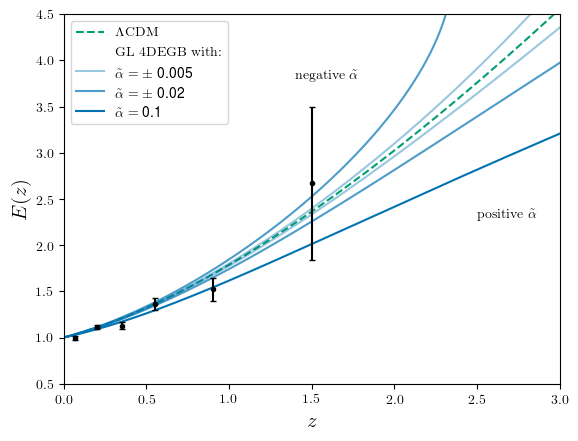

In [10]:
'''Plots of E(z)'''

col = sns.color_palette("colorblind") 
# best combinations are 0,2,4,9 and 1,3,5,8. Grey is 7

plt.plot(z,E(z , cosmoLCDM), color = col[2],linestyle= "--", label = r"$\Lambda\textrm{CDM}$")

plt.plot(0,0, alpha = 0, label = r"$\textrm{GL 4DEGB with:}$")
cosmo = [0.264 , 0.0493 , 0 , Omg_rad, 5e-3, 0]
plt.plot(z,E(z , cosmo), color = col[0], alpha = 0.4, label = r'$\tilde{\alpha} = \pm$ '+ str(cosmo[-2]))

cosmo = [0.264 , 0.0493 , 0 , Omg_rad, 2e-2, 0]
plt.plot(z,E(z , cosmo), color = col[0], alpha = 0.7, label = r'$\tilde{\alpha} = \pm$ '+ str(cosmo[-2]))

cosmo = [0.264 , 0.0493 , 0 , Omg_rad, 1e-1, 0]
plt.plot(z,E(z , cosmo), color = col[0], alpha = 1, label = r'$\tilde{\alpha} =  $'+ " " +str(cosmo[-2]))

# -------
cosmo = [0.264 , 0.0493 , 0 , Omg_rad, -5e-3, 0]
plt.plot(z,E(z , cosmo), color = col[0], alpha = 0.4)

cosmo = [0.264 , 0.0493 , 0 , Omg_rad, -2e-2, 0]
plt.plot(z,E(z , cosmo), color = col[0], alpha = 0.7)

plt.text(2.5, 2.3, r"$\textrm{positive }\tilde{\alpha}$", fontfamily = "Helvetica")
plt.text(1.4, 3.8, r"$\textrm{negative }\tilde{\alpha}$", fontfamily = "Helvetica")

plt.errorbar(z_dat, E_dat, yerr=E_err, fmt=".k", capsize=2)
plt.xlabel(r"$z$", size = 15)
plt.ylabel(r"$E(z)$", size = 15);
plt.xlim(0,3)
plt.ylim(0.5,4.5)

plt.legend()
#plt.savefig("E_z_GL_paper.pdf")


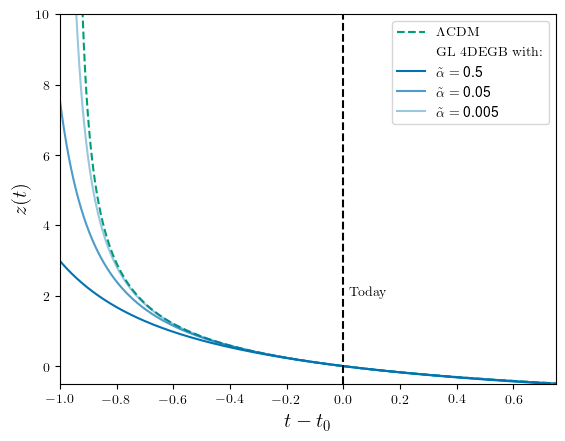

In [7]:
'''Plots of z(t)'''

z = np.linspace(-0.5, 10 , int(1e3))

plt.plot(unitless_time(z,cosmoLCDM) - unitless_time([0,0],cosmoLCDM)[0],z, color = col[2],linestyle= "--", label = r"$\Lambda \textrm{CDM}$")

plt.plot(0,0, alpha = 0, label = r"$\textrm{GL 4DEGB with:}$")

cosmo = [0.264 , 0.0493 , 0 , Omg_rad, 5e-1, 0]
plt.plot(unitless_time(z,cosmo) - unitless_time([0,0],cosmo)[0], z , color = col[0], alpha = 1, label = r'$\tilde{\alpha} =  $'+ " " +str(cosmo[-2]))
cosmo = [0.264 , 0.0493 , 0 , Omg_rad, 5e-2, 0]
plt.plot(unitless_time(z,cosmo) - unitless_time([0,0],cosmo)[0], z , color = col[0], alpha = 0.7, label = r'$\tilde{\alpha} =  $'+ " " +str(cosmo[-2]))
cosmo = [0.264 , 0.0493 , 0 , Omg_rad, 5e-3, 0]
plt.plot(unitless_time(z,cosmo) - unitless_time([0,0],cosmo)[0], z , color = col[0], alpha = 0.4, label = r'$\tilde{\alpha} =  $'+ " " +str(cosmo[-2]))
plt.plot(np.zeros(len(z)), z, "--k")
plt.text(0.02, 2.0, r"$\textrm{Today}$", fontfamily = "Helvetica")

plt.xlabel(r"$t - t_0$", size = 15)
plt.ylabel(r"$z(t)$", size = 15);
plt.legend()
plt.xlim(-1,0.75)
plt.ylim(-0.5,10)

#plt.savefig("z_of_t_paper.pdf")
plt.show()

In [8]:
'''Plots of Sound Horizon'''

mp.mp.dps = 50
h = 0.67

#Find quantities
a_LCDM = np.linspace(2e-9,1.5, int(1e3))
a = np.linspace(2e-9,1.5, int(1e3))

r_s_LCDM = np.zeros(len(a))
r_s1 = np.zeros(len(a))
r_s2 = np.zeros(len(a))
r_s3 = np.zeros(len(a))
cosmo1 = [0.264 , 0.0493 , 0 , Omg_rad, 5e-10, 0]
cosmo2 = [0.264 , 0.0493 , 0 , Omg_rad, 1e-11, 0]
cosmo3 = [0.264 , 0.0493 , 0 , Omg_rad, 1e-12, 0]

for i in range(len(a)):
    r_s_LCDM[i] = r_s_fracH0c(1/a_LCDM[i] - 1,cosmoLCDM, 2e-9)
    r_s1[i] = r_s_fracH0c(1/a[i] - 1 , cosmo1, 2e-9)
    r_s2[i] = r_s_fracH0c(1/a[i] - 1 , cosmo2, 2e-9)
    r_s3[i] = r_s_fracH0c(1/a[i] - 1 , cosmo3, 2e-9)

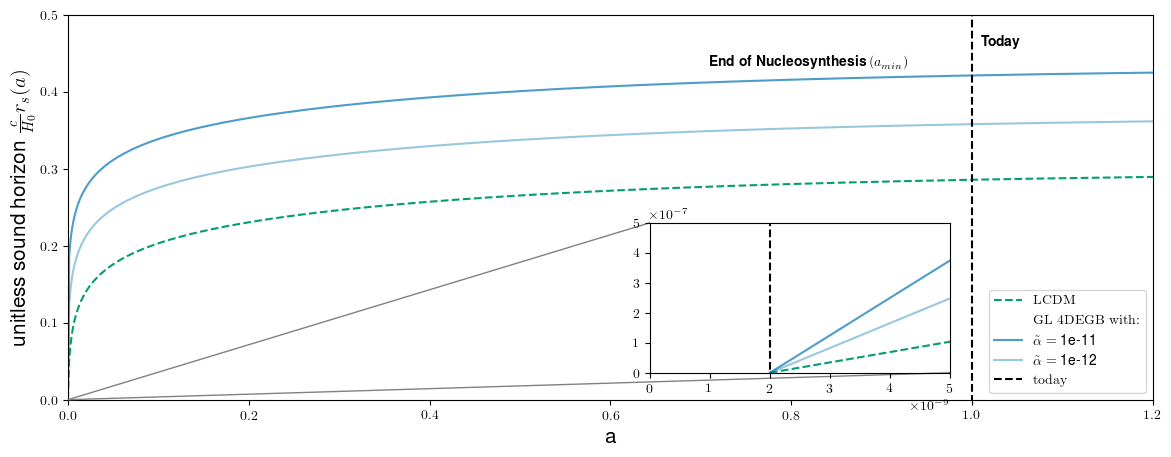

In [9]:
# Plot
fig = plt.figure(figsize=(14,5))
ax = plt.axes()

#big plot
ax.plot(a_LCDM,r_s_LCDM, label = r"$\textrm{LCDM}$", color = col[2], linestyle = "--")
ax.plot(0,0, alpha = 0, label = r"$\textrm{GL 4DEGB with:}$")
#ax.plot(a,r_s1, color = col[0], alpha = 1, label = r'$\tilde{\alpha} =  $'+ " " +str(cosmo1[-2]))
ax.plot(a,r_s2, color = col[0], alpha = 0.7, label = r'$\tilde{\alpha} =  $'+ " " +str(cosmo2[-2]))
ax.plot(a,r_s3, color = col[0], alpha = 0.4, label = r'$\tilde{\alpha} =  $'+ " " +str(cosmo3[-2]))
ax.plot(np.ones(int(1e2)), np.linspace(-1,3, int(1e2)), "k--", label = r"$\textrm{today}$")

# Make the zoom-in plot:
#axins = zoomed_inset_axes(ax, 80, loc=4) # zoom = 2
axins = inset_axes(ax, 3,1.5 , loc=4, bbox_to_anchor=(0.76, 0.15),bbox_transform=ax.figure.transFigure) # no zoom

axins.plot(a_LCDM,r_s_LCDM, label = "LCDM", color = col[2], linestyle = "--")
axins.plot(0,0, alpha = 0, label = "GL $4D$EGB with:")
#axins.plot(a,r_s1, color = col[0], alpha = 1)
axins.plot(a,r_s2, color = col[0], alpha = 0.7)
axins.plot(a,r_s3, color = col[0], alpha = 0.4)
axins.plot(2e-9*np.ones(int(1e2)), np.linspace(-1,1, int(1e2)), "k--")

axins.set_xlim(0, 5e-9)
axins.set_ylim(0, 0.5e-6)
#plt.xticks(visible=False)
#plt.yticks(visible=False)
mark_inset(ax, axins, loc1=2, loc2=4, fc="none", ec="0.5")

ax.text(1.01, 0.46, r"$\textbf{Today}$", fontfamily = "Helvetica")
axins.text(5e-9/5,1.025e-6, r"$\textbf{End of Nucleosynthesis }  (\large a_{min})$", fontfamily = "Helvetica")

ax.set_xlabel("a", size = 15)
ax.set_ylabel(r"unitless sound horizon $\frac{c}{H_0}r_s(a)$", size = 15)
ax.set_ylim(0,0.5)
ax.set_xlim(0,1.2)
ax.legend()
plt.draw()
#plt.savefig("soundhorizon_paper.pdf")
plt.show()

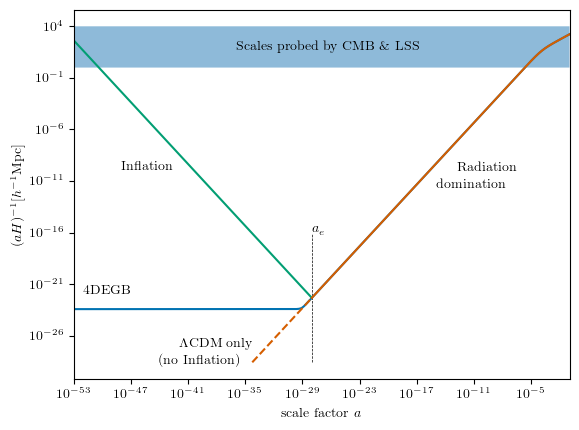

In [10]:
'''Plots for particle horizon'''
cosmo = [0.264 , 0.0493 , 0 , Omg_rad, 1e-112, 0]
z_CMB_val = z_CMB(cosmo[1],(cosmo[0]+cosmo[1]),h)


# Set the desired precision of Decimal
getcontext().prec = 120
alpha_t = Decimal('1e-112')
cosmotry = [Decimal('0.264'),Decimal('0.0493'),Decimal('0'),Decimal(str(Omg_rad)),alpha_t,Decimal('0')]
cosmotry_LCDM = [Decimal('0.264'),Decimal('0.0493'),Decimal('0'),Decimal(str(Omg_rad)),Decimal('0'),Decimal('0')]

a = np.logspace(-53,-1, int(1e3),dtype=np.dtype(Decimal))
for i in range(len(a)):
    a[i] = Decimal(a[i])

idx_a_e = find_nearest_idx(a, (alpha_t)**(Decimal('0.25')))

plt.plot((alpha_t)**(Decimal('0.25'))*np.ones(len(a[int(3*idx_a_e/4):int(5*idx_a_e/4)]),dtype=np.dtype(Decimal)), \
         Decimal('3e3')/(a[int(3*idx_a_e/4):int(5*idx_a_e/4)]*E(1/a[int(3*idx_a_e/4):int(5*idx_a_e/4)] - 1 , cosmotry_LCDM)), "k--", linewidth=0.5)


plt.plot(a, Decimal('3e3')/(a*E(1/a - 1 , cosmotry)), color = col[0])

plt.plot(a[:idx_a_e], Decimal('3e3')/(E(1/a[idx_a_e] - 1 , cosmotry_LCDM)) * 1/a[:idx_a_e], label = r"$\textrm{inflation}$", color = col[2])
plt.plot(a[idx_a_e:], Decimal('3e3')/(a[idx_a_e:]*E(1/a[idx_a_e:] - 1 , cosmotry_LCDM)), color = col[3])
plt.plot(a[int(3*idx_a_e/4):idx_a_e], Decimal('3e3')/(a[int(3*idx_a_e/4):idx_a_e]*E(1/a[int(3*idx_a_e/4):idx_a_e] - 1 , cosmotry_LCDM)), color = col[3], linestyle="--")

plt.text(1e-15, 1e-10, r"$\textrm{Radiation}\newline\textrm{domination}$", fontfamily = "Helvetica")
plt.text(1e-48, 1e-10, r"$\textrm{Inflation}$", fontfamily = "Helvetica")
plt.text(1e-28, 1e-16, r"$a_e$", fontfamily = "Helvetica")
plt.text(1e-52, 1e-22, r"$\textrm{4DEGB}$", fontfamily = "Helvetica")
plt.text(1e-44, 1e-27, r"$\Lambda\textrm{CDM only}\newline\textrm{(no Inflation)}$", fontfamily = "Helvetica")
plt.text(1e-36, 5e1, r"$\textrm{Scales probed by CMB \& LSS}$", fontfamily = "Helvetica")

plt.fill_between(a, 1, 1e4, alpha = 0.5)

plt.xscale("log")
plt.yscale("log")
plt.xlim(1e-53,1e-1)
plt.xlabel(r"$\textrm{scale factor } a$")
plt.ylabel(r"$(aH)^{-1} [h^{-1}\textrm{Mpc]}$")
#plt.savefig("particlehorizon_paper.pdf")
plt.show()

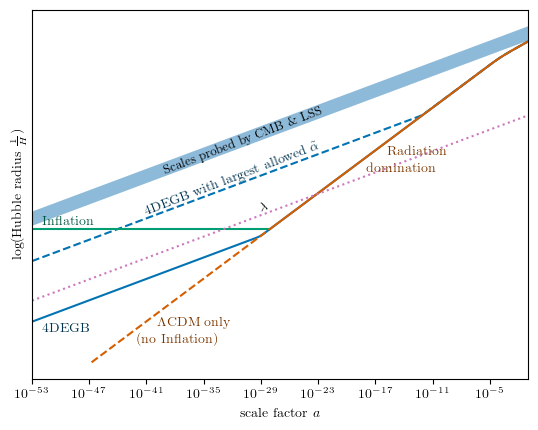

In [11]:
'''Plots for particle horizon - seed perturbations'''
# plots inspired by https://ned.ipac.caltech.edu/level5/Narlikar/Narlikar3_1.html
h = 0.67
cosmo = [0.264 , 0.0493 , 0 , Omg_rad, 1e-112, 0]
z_CMB_val = z_CMB(cosmo[1],(cosmo[0]+cosmo[1]),h)

# Set the desired precision of Decimal
getcontext().prec = 120
alpha_t = Decimal('1e-112')
cosmotry = [Decimal('0.264'),Decimal('0.0493'),Decimal('0'),Decimal(str(Omg_rad)),alpha_t,Decimal('0')]
cosmotry2 = [Decimal('0.264'),Decimal('0.0493'),Decimal('0'),Decimal(str(Omg_rad)),Decimal('1e-44'),Decimal('0')]
cosmotry_LCDM = [Decimal('0.264'),Decimal('0.0493'),Decimal('0'),Decimal(str(Omg_rad)),Decimal('0'),Decimal('0')]

a = np.logspace(-53,-1, int(1e3),dtype=np.dtype(Decimal))
for i in range(len(a)):
    a[i] = Decimal(a[i])

idx_a_e = find_nearest_idx(a, (alpha_t)**(Decimal('0.25')))

plt.fill_between(a, a, Decimal('1e4')*a, alpha = 0.5)
plt.text(1e-39, 4e-39, r"$\textrm{\small Scales probed by CMB \& LSS}$", color = 'k', rotation = 21,
         rotation_mode = 'anchor')

plt.plot(a, 1/(E(1/a - 1 , cosmotry)), color = col[0])
plt.plot(a, 1/(E(1/a - 1 , cosmotry2)), color = col[0], linestyle = "--")

plt.plot(a[:idx_a_e], 1/(E(1/a[idx_a_e] - 1 , cosmotry_LCDM))*np.ones(len(a[:idx_a_e]),dtype=np.dtype(Decimal)), label = r"$\textrm{inflation}$", color = col[2])
plt.plot(a[idx_a_e:], 1/(E(1/a[idx_a_e:] - 1 , cosmotry_LCDM)), color = col[3])
plt.plot(a[int(idx_a_e/4):idx_a_e], 1/(E(1/a[int(idx_a_e/4):idx_a_e] - 1 , cosmotry_LCDM)), color = col[3], linestyle="--")
plt.plot(a, Decimal('1e-21')*a, color = col[4], linestyle=":")
#plt.plot(a, Decimal('0.005')*a, color = col[4], linestyle=":")

plt.text(1e-18, 1e-33, r"$\textrm{Radiation}\newline\textrm{domination}$", fontfamily = "Helvetica", color = lighten_color(col[3], 1.3))
plt.text(1e-52, 1e-53, r"$\textrm{Inflation}$", fontfamily = "Helvetica", color = lighten_color(col[2], 1.2))
plt.text(1e-52, 1e-83, r"$\textrm{4DEGB}$", fontfamily = "Helvetica", color = lighten_color(col[0], 1.3))
plt.text(1e-41, 1e-50, r"$\textrm{4DEGB with largest allowed }\tilde{\alpha}$", 
         fontfamily = "Helvetica", color = lighten_color(col[0], 1.3), rotation = 21,
         rotation_mode = 'anchor')
plt.text(1e-42, 1e-81, r"$\Lambda\textrm{CDM only}\newline\textrm{(no Inflation)}$", fontfamily = "Helvetica", color = lighten_color(col[3], 1.3))

plt.text(1e-29, 1e-49, r'$\lambda$',
         color = 'k', rotation = 21,
         rotation_mode = 'anchor')

plt.xscale("log")
plt.yscale("log")
plt.xlim(1e-53,1e-1)
plt.xlabel(r"$\textrm{scale factor } a$")
plt.ylabel(r"$\textrm{log}(\textrm{Hubble radius } \frac{1}{H})$")
plt.gca().axes.get_yaxis().set_ticks([])
#plt.savefig("particlehorizon_lengths_paper.pdf")
plt.show()

## Perturbations

In [189]:
""" Define cosmology and scales """
# ---- COSMOLOGY, SCALES AND BOUNDARY CONDITIONS -----

# note: k is unitless (ie. k is actually k/H0)
# for simga_8, k = 2pi/(8h^-1 Mpc) \implies k/H0 = 3e5*pi/400

k_val = np.logspace(-3, 0, 300)*(3e5/100)

# Decide on some coordinate times
x_val = np.linspace( -2, 0 , 100)
a_val = np.exp(x_val)
z_val = 1/a_val - 1

# Decide on some background cosmology = Omega_c , Omega_b , Omega_k , Omega_r , alpha_C
cosmo_LCDM_array = [0.27 , 0.045, 0 ,9.227e-5 , 0.0]
cosmo = [0.27 , 0.045, 0 ,9.227e-5 , 1e-5]

# Background cosmology for pyccl
cosmoLCDM = ccl.core.Cosmology(Omega_c=cosmo[0],
                               Omega_b=cosmo[1], 
                               sigma8=0.81,
                               h = 0.67,
                               n_s=0.96,
                               Omega_k=cosmo[2], 
                               Omega_g=cosmo[3])

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

idx_sigma = find_nearest(k_val, 3e5*np.pi/400)
print("error in k_simga8 = ", 100*abs(3e5*np.pi/400 - k_val[idx_sigma])/(3e5*np.pi/400), "%")

error in k_simga8 =  1.0591568343275144 %


In [190]:
""" Find D+, f and fsigma8"""

solution_growth = solve_for_growth(a_val, cosmo, k_val)
solution_growth_LCDM = solve_for_growth(a_val, cosmo_LCDM_array, k_val)
# get LCDM for only some values of k for the plot to compare to 4DEGB
k_ex1 = k_val[int(len(k_val)/2)-5: int(len(k_val)/2) + 5]
solution_growth_LCDM_ex1 = solve_for_growth(a_val, cosmo_LCDM_array, k_ex1)

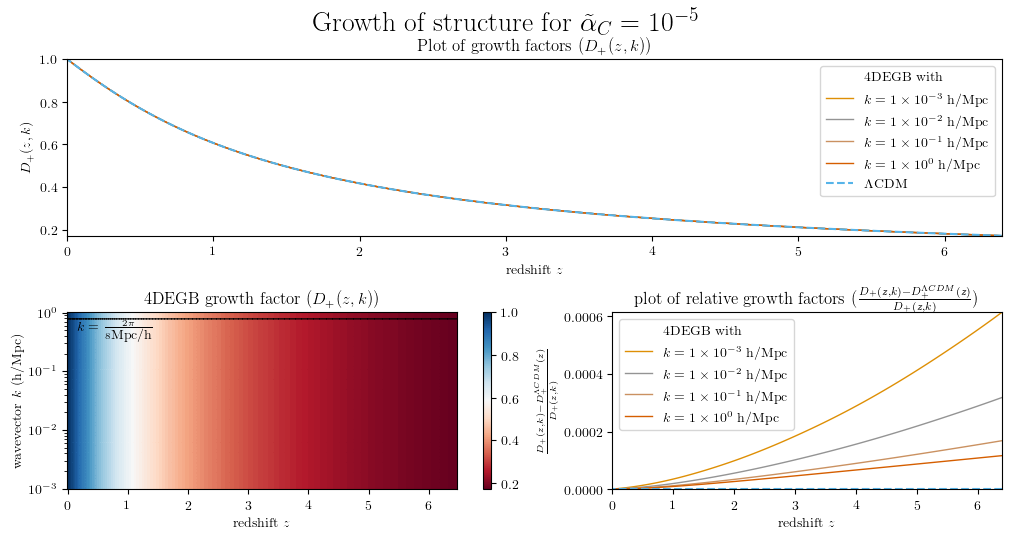

In [191]:
"""Linear Growth factor D+(a) plots"""

#fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharex=True)
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
axs = fig.subplot_mosaic([['Top', 'Top'],['BLeft', 'BRight']],
                          gridspec_kw={'width_ratios':[1, 1]})

col = sns.color_palette("colorblind") 
# best combinations are 0,2,4,9 and 1,3,5,8. Grey is 7

# X AND Y AXIS VALUES USED
# Full k space
X, Y = np.meshgrid(z_val, k_val/(3e5/100))
# k space for black lines
X_blackline, Y_blackline = np.meshgrid(z_val, [k_val[int(len(k_val)/2)-7]/(3e5/100),k_val[int(len(k_val)/2)-6]/(3e5/100)])
X_blackline1, Y_blackline1 = np.meshgrid(z_val, [k_val[int(len(k_val)/2)+5]/(3e5/100),k_val[int(len(k_val)/2)+6]/(3e5/100)])
# k value for 8 Mpc/h
X_8, Y_8 = np.meshgrid(z_val, [np.pi/4+0.005, np.pi/4 -0.005])
# CMB value
X_CMB, Y_CMB = np.meshgrid([1/1101 - 1e-6, 1/1101 + 1e-6] , k_val/(3e5/100))

"""
# PLOT OF RELATIVE D+(a)
ax = axs[1][0]
Z = (solution_growth[0]-solution_growth_LCDM[0])/solution_growth[0]
c = ax.pcolor(X, Y, Z,vmin=Z.min(), vmax=Z.max(), alpha = 1, cmap='RdBu')
ax.set_title(r'$\textrm{4DEGB growth factor relative to } \Lambda CDM \textrm{ }(\frac{D_{+}(z,k) - D_{+}^{\Lambda CDM}(z)}{D_{+}(z,k)})$')
ax.set_ylabel(r'$\textrm{wavevector }k \textrm{ (h/Mpc)}$')
# Line for CMB
#c2 = ax.pcolor(X_CMB, Y_CMB, np.zeros((len(k_val),2)), vmin=-10, vmax=0, alpha = 0.5, cmap='Greys')
#ax.text(1e-3, 0.5, r"CMB")
fig.colorbar(c, ax=ax)
ax.set_yscale("log")
ax.set_xlabel(r'$\textrm{redshift }z$')
"""
# PLOTS OF D+(a) OF 4DEGB AND LCDM
ax = axs['BLeft']
Z = solution_growth[0]
# Plot of 4DEGB growth rate
c = ax.pcolor(X, Y, Z, vmin=Z.min(), vmax=Z.max(), alpha = 1, cmap='RdBu')
# Line for 8 Mpc/h ---- TODO ------------------------------------------------------------------------------------
c2 = ax.pcolor(X_8, Y_8, np.zeros((2,len(z_val))), vmin=-10, vmax=0, alpha = 0.5, cmap='Greys')
ax.text(0.15, 5e-1, r"$k = \frac{2 \pi}{8\textrm{Mpc/h}}$")
# Line for CMB
#c2 = ax.pcolor(X_CMB, Y_CMB, np.zeros((len(k_val),2)), vmin=-10, vmax=0, alpha = 0.5, cmap='Greys')
#ax.text(1e-3, 0.5, r"CMB")

ax.set_title(r'$\textrm{4DEGB growth factor }(D_{+}(z,k))$')
ax.set_ylabel(r'$\textrm{wavevector }k\textrm{ (h/Mpc)}$')
ax.set_yscale("log")
ax.set_xlabel(r"$\textrm{redshift }z$")

fig.colorbar(c, ax=ax, pad=-0.02)

# 2D PLOTS OF D+(a)
ax = axs['Top']
ax.plot(1,0, alpha = 0, label = r"$\textrm{4DEGB with}$")
ax.plot(z_val, Z[0], label = r"$k = %.0f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[0]/3000)-int(np.log10(k_val[0]/3000)-0.1)), int(np.log10(k_val[0]/3000)-0.1))\
        , linewidth =1, color = col[1])
ax.plot(z_val, Z[-280], label = r"$k = %.0f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[-200]/3000)-int(np.log10(k_val[-200]/3000)-0.1)), int(np.log10(k_val[-200]/3000)-0.1))\
        , linewidth =1, color = col[7])
ax.plot(z_val, Z[-250], label = r"$k = %.0f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[-100]/3000)-int(np.log10(k_val[-100]/3000) -0.1)), int(np.log10(k_val[-100]/3000)-0.1))\
        , linewidth =1, color = col[5])
ax.plot(z_val, Z[-1], label = r"$k = %.0f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[-1]/3000)-int(np.log10(k_val[-1]/3000)-0.1)), int(np.log10(k_val[-1]/3000)-0.1))\
        , linewidth =1, color = col[3])
ax.plot(z_val, solution_growth_LCDM[0][int(len(k_val)/2)], color = col[9], linestyle = "--", label = r"$\Lambda \textrm{CDM}$")
#CMB
#ax.plot(1/1101*np.ones(len(z_val)), np.linspace(0,1,len(z_val)), linestyle = "--", color = "k")
#ax.text(1e-3, 0.5, r"CMB")

#ax.text(1e-4, 0.2e-3, r"$\Lambda CDM$")
ax.set_ylabel(r"$D_{+}(z,k)$")
ax.set_xlim(z_val[-1],z_val[0])
ax.set_ylim(solution_growth_LCDM[0][int(len(k_val)/2)][0],solution_growth_LCDM[0][int(len(k_val)/2)][-1])
ax.set_title(r'$\textrm{Plot of growth factors }(D_{+}(z,k))$')
ax.set_xlabel(r"$\textrm{redshift }z$")
ax.legend()

# 2D PLOTS OF RELATIVE D+(a)
ax = axs['BRight']
ax.plot(1,0, alpha = 0, label = r"\textrm{4DEGB with}")
Z = (solution_growth[0]-solution_growth_LCDM[0])/solution_growth[0]
ax.plot(z_val, Z[0], label = r"$k = %.0f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[0]/3000)-int(np.log10(k_val[0]/3000)-0.1)), int(np.log10(k_val[0]/3000)-0.1))\
        , linewidth =1, color = col[1])
ax.plot(z_val, Z[-280], label = r"$k = %.0f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[-200]/3000)-int(np.log10(k_val[-200]/3000)-0.1)), int(np.log10(k_val[-200]/3000)-0.1))\
        , linewidth =1, color = col[7])
ax.plot(z_val, Z[-250], label = r"$k = %.0f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[-100]/3000)-int(np.log10(k_val[-100]/3000) -0.1)), int(np.log10(k_val[-100]/3000)-0.1))\
        , linewidth =1, color = col[5])
ax.plot(z_val, Z[-1], label = r"$k = %.0f \times 10^{%d} \textrm{ h/Mpc}$" % \
        (10**(np.log10(k_val[-1]/3000)-int(np.log10(k_val[-1]/3000)-0.1)), int(np.log10(k_val[-1]/3000)-0.1))\
        , linewidth =1, color = col[3])
ax.plot(z_val, np.zeros(len(z_val)), color = col[9], linestyle = "--")
#CMB
#ax.plot(1/1101*np.ones(len(z_val)), np.linspace(0,1,len(z_val)), linestyle = "--", color = "k")
#ax.text(1e-3, 0.9, r"CMB")

#ax.plot(z_val, solution_growth_LCDM[0][int(len(k_val)/2)], label = "LCDM", color = col[9])
ax.legend()
ax.set_title(r'$\textrm{plot of relative growth factors }(\frac{D_{+}(z,k) - D_{+}^{\Lambda CDM}(z)}{D_{+}(z,k)})$')
ax.set_ylabel(r"$\frac{D_{+}(z,k) - D_{+}^{\Lambda CDM}(z)}{D_{+}(z,k)}$")
ax.set_xlabel(r"$\textrm{redshift }z$")
ax.set_xlim(z_val[-1],z_val[0])
ax.set_ylim(Z[0][-1],Z[0][0])
#plt.pcolor(X_LCDM, Y_LCDM, np.zeros((len(k_val[450:550]),len(z_val))))
#fig.tight_layout()
fig.suptitle(r'$\textrm{Growth of structure for } \tilde{\alpha}_C = 10^{-5}$', fontsize=20, y=1.05)
#plt.savefig("Growth_LSS_regimes.pdf", bbox_inches='tight')
plt.show()

In [203]:
# Define new scales for CMB comparison
k_val = np.logspace(-3, 0, 300)*(3e5/100)

# Decide on some coordinate times
x_val = np.linspace( -8.5, 0 , 100)
a_val = np.exp(x_val)
z_val = 1/a_val - 1

# Decide on some background cosmology = Omega_c , Omega_b , Omega_k , Omega_r , alpha_C
cosmo_LCDM_array = [0.27 , 0.045, 0 ,9.227e-5 , 0.0]
cosmo = [0.27 , 0.045, 0 ,9.227e-5 , 1e-5]

# Background cosmology for pyccl
cosmoLCDM = ccl.core.Cosmology(Omega_c=cosmo[0],
                               Omega_b=cosmo[1], 
                               sigma8=0.81,
                               h = 0.67,
                               n_s=0.96,
                               Omega_k=cosmo[2], 
                               Omega_g=cosmo[3])

""" Find D+, f and fsigma8"""

solution_growth = solve_for_growth(a_val, cosmo, k_val)
solution_growth_LCDM = solve_for_growth(a_val, cosmo_LCDM_array, k_val)
# get LCDM for only some values of k for the plot to compare to 4DEGB
k_ex1 = k_val[int(len(k_val)/2)-5: int(len(k_val)/2) + 5]
solution_growth_LCDM_ex1 = solve_for_growth(a_val, cosmo_LCDM_array, k_ex1)

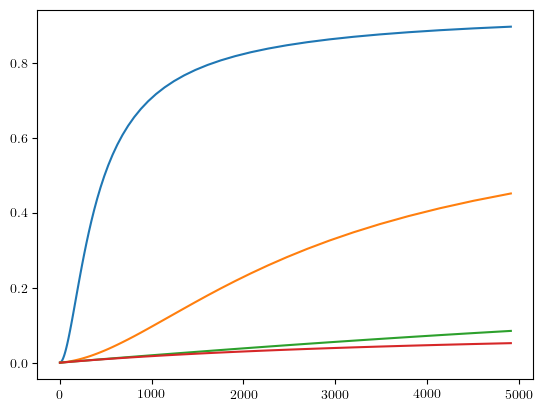

In [206]:
Z = (solution_growth[0]-solution_growth_LCDM[0])/solution_growth[0]

plt.plot(z_val, Z[0])
plt.plot(z_val, Z[-200])
plt.plot(z_val, Z[-100])
plt.plot(z_val, Z[-1])